# CS4168 Data Mining

## Lab 4: Comparison of Classifiers

**David Walsh 20276885**

*To Do:*
* Replicate the classifier training and evaluation demonstrated in the example notebook Lab 4 - Comparison of Binary Classifiers.ipynb but with the dataset seeds.csv. You will need to formulate a binary classification problem and transform the type column accordingly. That is, replace the type column with a binary column called class in which one of the original three types (it doesn't matter which one you choose) is class 0, and the other two types are class 1.
* Train a third probabilistic classifier (e.g., MLPClassifier, Naive Bayes, kNN) with seeds.csv add compare it to both SVM and Random Forest. You may encounter warnings for 0 values of some of the metrics. Ignore them and aim at having at least one classifier that has acceptable results.

In [57]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import set_config, svm
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, auc, precision_recall_fscore_support, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer, RobustScaler, StandardScaler

%matplotlib inline

## 1. EDA - Exploratory Data Analysis

In [58]:
df = pd.read_csv("./seeds.csv")

In [59]:
df.head(6)

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1
5,14.38,14.21,0.8951,5.386,3.312,2.462,4.956,1


In [60]:
df.tail(6)

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type
204,12.37,13.47,0.8567,5.204,2.960,3.919,5.001,3
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,3
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,3
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,3
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,3
209,12.30,13.34,0.8684,5.243,2.974,5.637,5.063,3


In [61]:
df.shape

(210, 8)

In [62]:
df['type'].value_counts()

1    70
2    70
3    70
Name: type, dtype: int64

In [63]:
df.isna().sum()

area                       0
perimeter                  0
compactness                0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
type                       0
dtype: int64

* There are no missing values.
* Will now check the boxplots of the numerical columns for outliers.

In [64]:
df.loc[:, 'area' : 'length of kernel groove'].describe()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,14.847524,14.559286,0.870999,5.628533,3.258605,3.700201,5.408071
std,2.909699,1.305959,0.023629,0.443063,0.377714,1.503557,0.491480
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000
25%,12.270000,13.450000,0.856900,5.262250,2.944000,2.561500,5.045000
50%,14.355000,14.320000,0.873450,5.523500,3.237000,3.599000,5.223000
75%,17.305000,15.715000,0.887775,5.979750,3.561750,4.768750,5.877000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.456000,6.550000


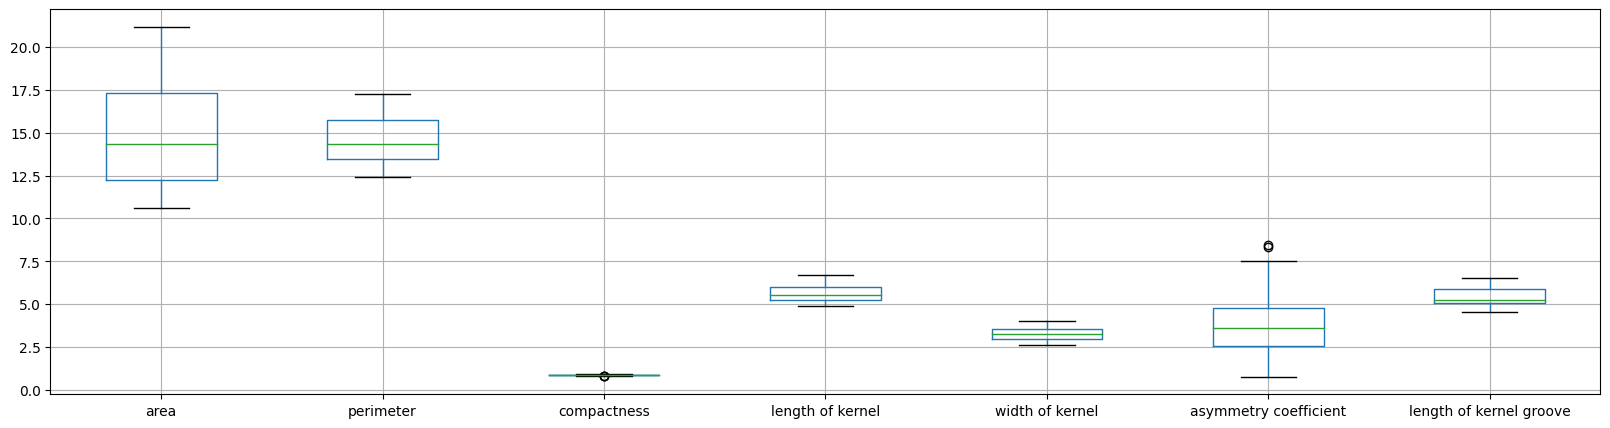

In [65]:
df.loc[:, 'area' : 'length of kernel groove'].boxplot(figsize = (20, 5))
plt.show()

* Only `compactness` and `asymmetry coefficient` have outliers.
* Will apply RobustScaler to them.

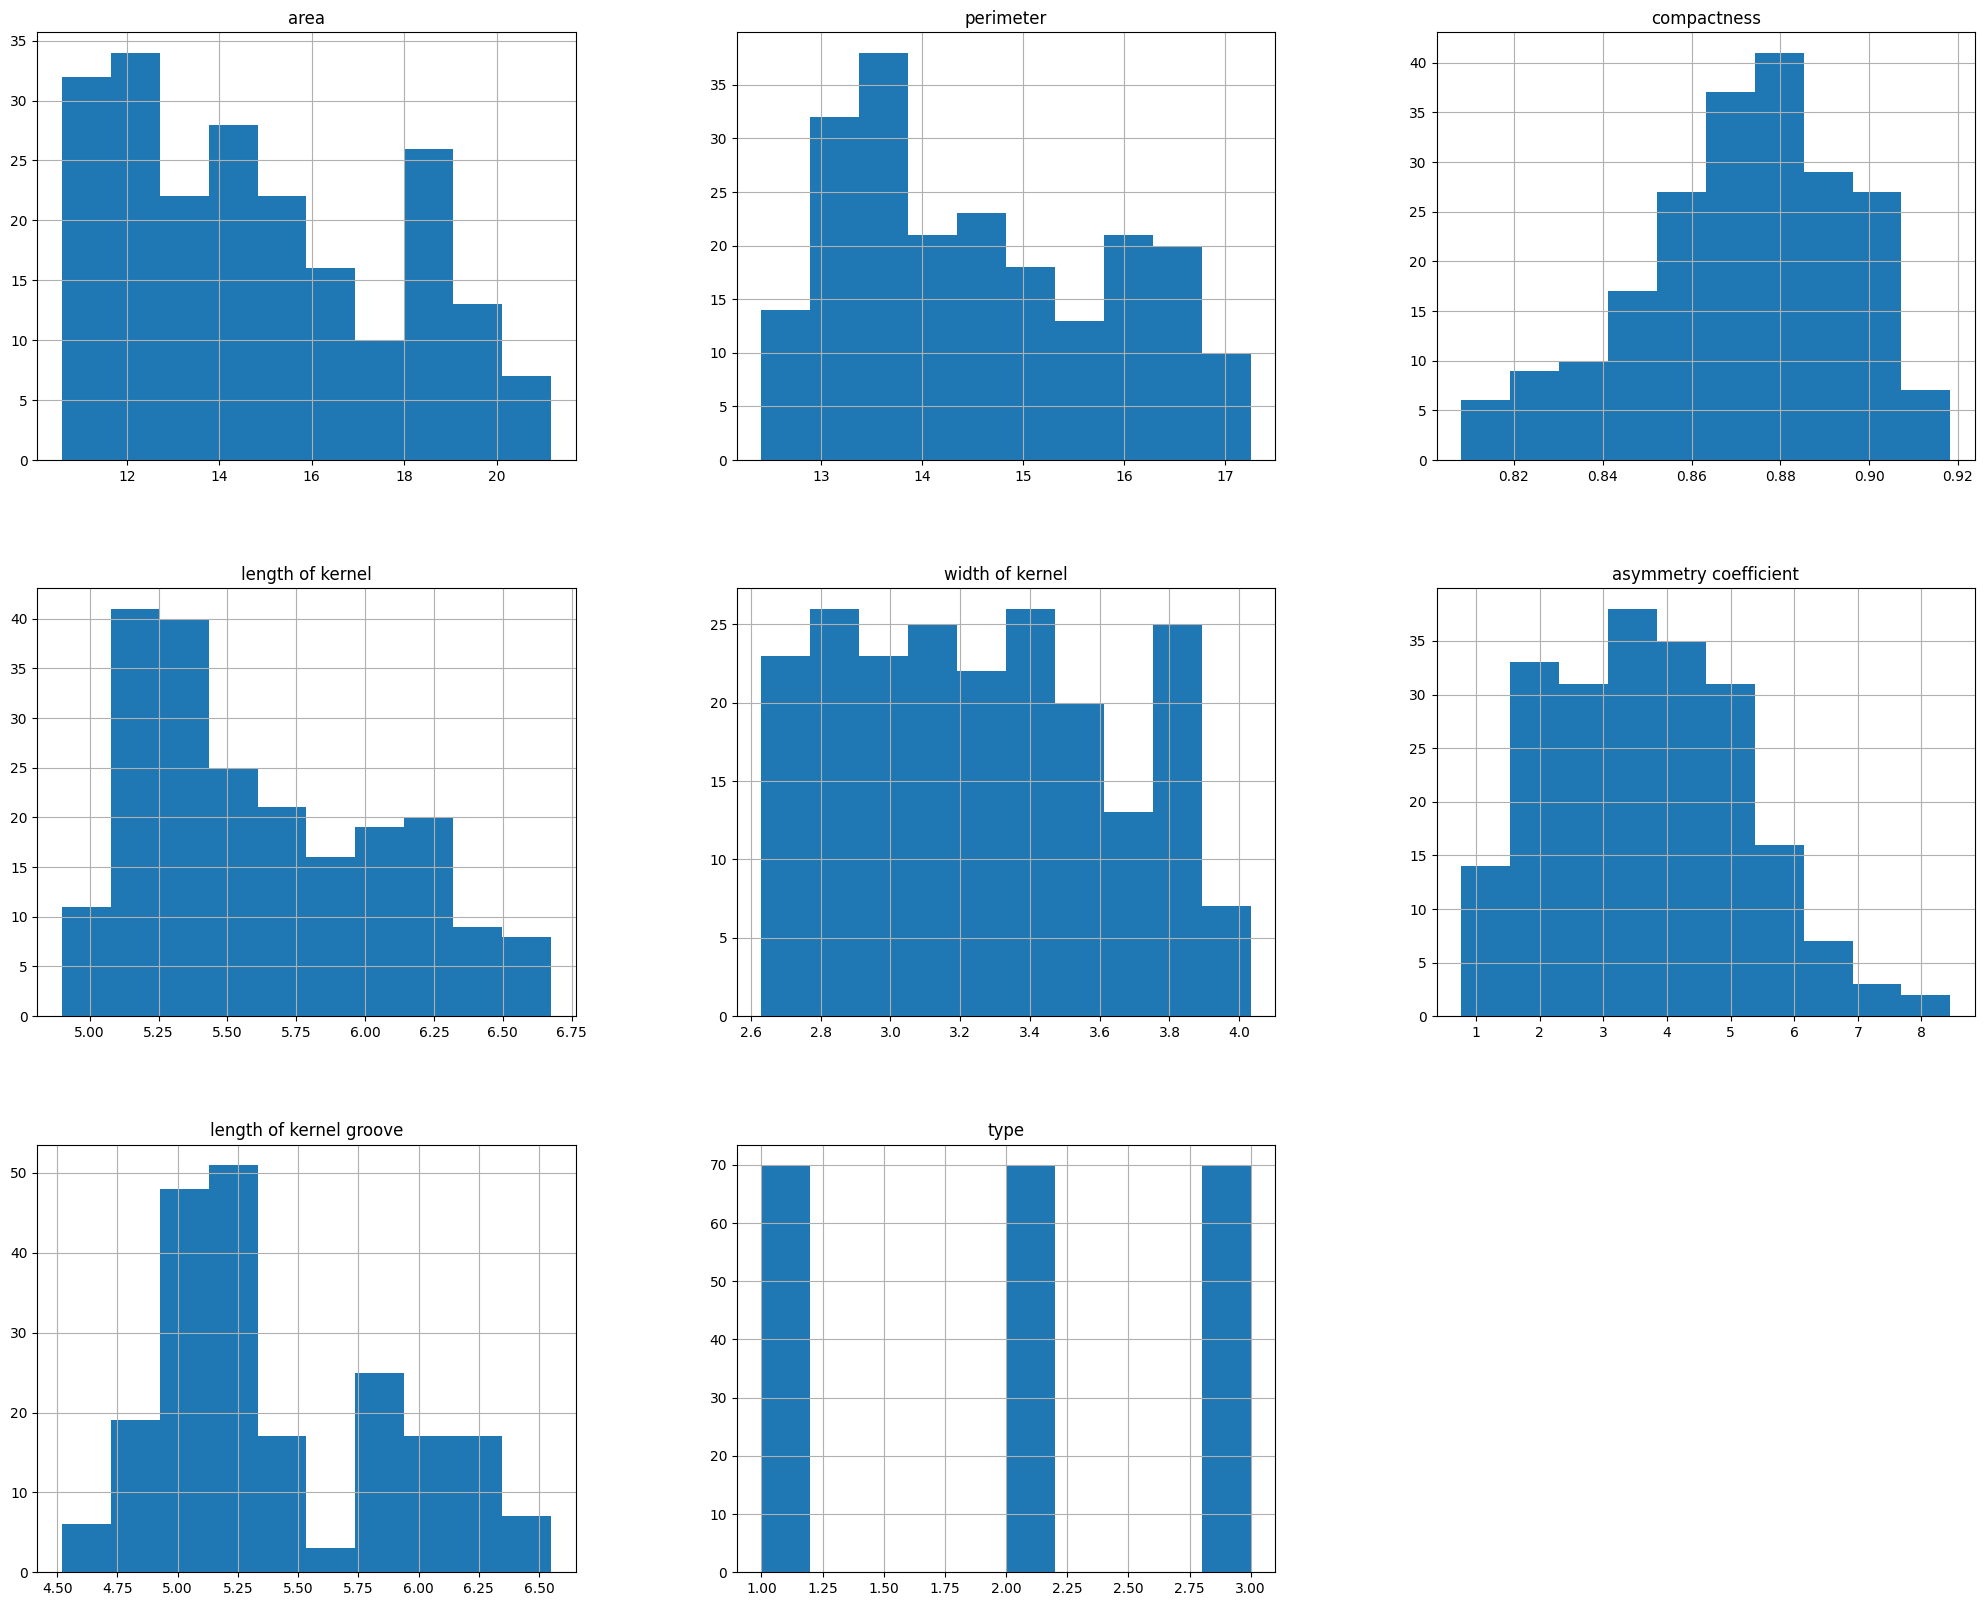

In [66]:
df.hist(bins = 10, figsize = (25, 20));

* Around 5 attributes have a slight right skew while compactness has a left skew.
* No attributes have zeroes.

## 2. Data Preparation

Designating:
* type 1 as class 0
* type 2 as class 1
* type 3 as class 1

In [67]:
df['class'] = df['type'].replace({1 : 0, 2 : 1, 3 : 1})

In [68]:
df['class'].value_counts()

1    140
0     70
Name: class, dtype: int64

In [69]:
df = df.drop('type', axis = 1)

In [70]:
# Storing a list with the names of all predictors
names_all = [c for c in df if c not in ['class']]

# Defining column groups with same data preparation
names_no_outliers = ['compactness', 'asymmetry coefficient'] # Group 1
names_outliers_and_zeros = []; # Group 2
names_outliers_no_zeros = list(set(names_all) - set(names_no_outliers) - set(names_outliers_and_zeros)) # Group 3, all other predictors

# Verifing the correct columns are selected
print(names_outliers_no_zeros)
print(len(names_outliers_no_zeros))

['area', 'length of kernel', 'perimeter', 'length of kernel groove', 'width of kernel']
5


In [71]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

In [72]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

In [73]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("outliers_no_zeros", make_pipeline(
            ColumnSelector(columns=names_outliers_no_zeros),
            FunctionTransformer(np.log),
            RobustScaler()
        )),
        # ("outliers_with_zeros", make_pipeline(
        #     ColumnSelector(columns=names_outliers_and_zeros),
        #     FunctionTransformer(np.cbrt),
        #     RobustScaler()
        # )),
        ("no_outliers", make_pipeline(
            ColumnSelector(columns=names_no_outliers),
            FunctionTransformer(np.cbrt),
        ))
    ])
)

In [74]:
y = df['class']
X = df.drop('class', axis = 1).values

# Splitting the dataset into a training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, stratify = y)

print(X)

[[15.26   14.84    0.871  ...  3.312   2.221   5.22  ]
 [14.88   14.57    0.8811 ...  3.333   1.018   4.956 ]
 [14.29   14.09    0.905  ...  3.337   2.699   4.825 ]
 ...
 [13.2    13.66    0.8883 ...  3.232   8.315   5.056 ]
 [11.84   13.21    0.8521 ...  2.836   3.598   5.044 ]
 [12.3    13.34    0.8684 ...  2.974   5.637   5.063 ]]


## 3. Model Training

### 3.1 SVM

In [75]:
# Create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('svm', svm.SVC(probability = True))])

# Prepare a prameter grid
# Note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# Note also that this is not an exhaustive list of the parameters of svn.SVC and their possible values

param_grid = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': [1, 0.1, 0.01, 0.001],
    'svm__kernel': ['rbf', 'linear', 'poly']}

search = GridSearchCV(pipe, param_grid, n_jobs = -1, cv = 5, refit = True)
search.fit(X_train, y_train) # Training happens here, SVM is trained 48x5 = 240 times

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# Store the best params and best model for later use
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 0.970:
Best parameters:  {'svm__C': 100, 'svm__gamma': 1, 'svm__kernel': 'poly'}


### 3.2 Random Forest

In [76]:
# Create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', RandomForestClassifier())])

# Prepare a prameter grid
# Note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# Note also that this is not an exhaustive list of the parameters of RandomForestClassifier and their possible values
param_grid = {
    'rf__n_estimators' : [10, 20, 30],
    'rf__max_depth': [2, 4, 6, 8]
}

search = GridSearchCV(pipe, param_grid, n_jobs = -1, cv = 5, refit = True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# Store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.917:
Best parameters:  {'rf__max_depth': 8, 'rf__n_estimators': 30}


### 3.3 Naive Bayes

In [77]:
# Create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('naive_bayes', GaussianNB())])

# Note: Naive Bayes does not require the same parameter grid as it doesn't use neighbors, weights, or metric
# Simplify the search by focusing on parameters relevant to Naive Bayes if needed
# For GaussianNB, often no parameters need to be tuned, adjust 'var_smoothing' if desired

# Prepare a parameter grid
param_grid = {
    'naive_bayes__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# Store the best params and best model for later use
NB_best_params = search.best_params_
NB_best_model = search.best_estimator_

Best CV score = 0.875:
Best parameters:  {'naive_bayes__var_smoothing': 1e-09}


## 4. Compare Classifiers on Test Set

In [78]:
mean_fpr = np.linspace(start = 0, stop = 1, num = 100)

In [79]:
# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the classifier learns to predict probabilities for the examples to belong to class 1

def evaluate_model(X_test, y_test, model):
    # Compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]

    # Compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)

    # Compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)

    # Compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])

    # Compute fpr and tpr values for various thresholds
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)

    # Compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])

    # Compute the area under the curve
    _auc = auc(_fpr, _tpr)

    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

In [80]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)

RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)

NB_accuracy, NB_precision, NB_recall, NB_f1_score, NB_tpr, NB_auc = evaluate_model(X_test, y_test, NB_best_model)

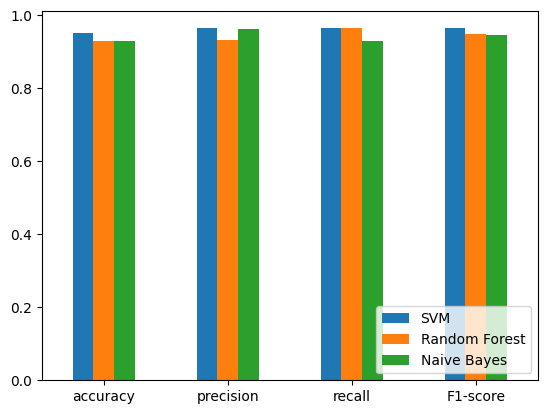

In [81]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
NB_metrics = np.array([NB_accuracy, NB_precision, NB_recall, NB_f1_score])

index = ['accuracy', 'precision', 'recall', 'F1-score']

df_metrics = pd.DataFrame({
    'SVM': SVM_metrics,
    'Random Forest': RF_metrics,
    'Naive Bayes': NB_metrics
    }, index = index)
df_metrics.plot.bar(rot = 0)
plt.legend(loc = "lower right")
plt.show()

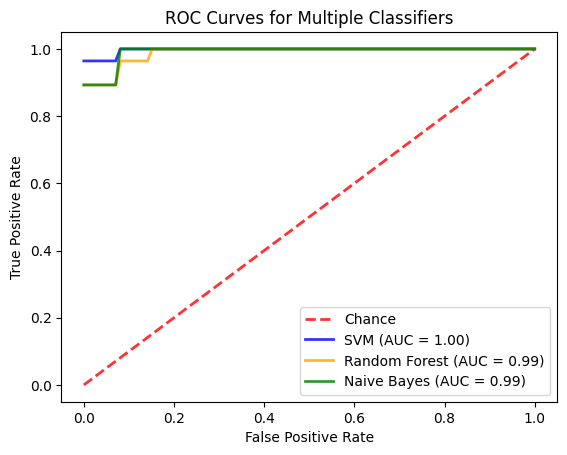

In [82]:
plt.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'r', label = 'Chance', alpha = 0.8)
plt.plot(mean_fpr, SVM_tpr[0, :], lw = 2, color = 'blue', label = 'SVM (AUC = %0.2f)' % (SVM_auc), alpha = 0.8)
plt.plot(mean_fpr, RF_tpr[0, :], lw = 2, color = 'orange', label = 'Random Forest (AUC = %0.2f)' % (RF_auc), alpha = 0.8)
plt.plot(mean_fpr, NB_tpr[0, :], lw = 2, color = 'green', label = 'Naive Bayes (AUC = %0.2f)' % (NB_auc), alpha = 0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multiple Classifiers')
plt.legend(loc = "lower right")
plt.show()

* The ROC curves confirm that all classifiers perform significantly better than a random guess (the red dashed `no skill` line).

## 5. Train a Final Model

In [83]:
# Function to remove the string 'svm__' from the names of the parameters in SVM_best_params
def transform(dict):
    return {key.replace('svm__', '') :  value for key, value in dict.items()}

pipe = make_pipeline(preprocess_pipeline, svm.SVC(**transform(SVM_best_params)))

final_model = pipe.fit(X, y)

In [84]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))